# Проект по А/B-тестированию

***Постановка задачи***

    Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
    Оцените корректность проведения теста.
    Проанализируйте результаты теста.
    Чтобы оценить корректность проведения теста, проверьте:
    пересечение тестовой аудитории с конкурирующим тестом;
    совпадение теста и маркетинговых событий, другие проблемы временных границ теста.
    
***Техническое задание***

    Название теста: recommender_system_test;
    Группы: А (контрольная), B (новая платёжная воронка);
    Дата запуска: 2020-12-07;
    Дата остановки набора новых пользователей: 2020-12-21;
    Дата остановки: 2021-01-04;
    Аудитория: 15% новых пользователей из региона EU;
    Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
    Ожидаемое количество участников теста: 6000.
    Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    конверсии в просмотр карточек товаров — событие product_page
    просмотры корзины — product_cart
    покупки — purchase.
    
# Загрузите данные теста, проверьте корректность его проведения и проанализируйте полученные результаты.
    
***Данные***

    ab_project_marketing_events.csv
    final_ab_new_users.csv
    final_ab_events.csv
    final_ab_participants.csv
    
`/datasets/ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год;
    
    Структура файла:
    name — название маркетингового события;
    regions — регионы, в которых будет проводиться рекламная кампания;
    start_dt — дата начала кампании;
    finish_dt — дата завершения кампании.
    
`/datasets/final_ab_new_users.csv` — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;

    Структура файла:
    user_id — идентификатор пользователя;
    first_date — дата регистрации;
    region — регион пользователя;
    device — устройство, с которого происходила регистрация.
    
`/datasets/final_ab_events.csv` — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
    
    Структура файла:
    user_id — идентификатор пользователя;
    event_dt — дата и время события;
    event_name — тип события;
    details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.
    
`/datasets/final_ab_participants.csv` — таблица участников тестов.

    Структура файла:
    user_id — идентификатор пользователя;
    ab_test — название теста;
    group — группа пользователя.


# Загрузим исходные данные

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import re
#%pip install plotly --upgrade
from plotly import graph_objects as go
import math as mth
from scipy import stats as st

In [2]:
try:
    final_ab_events, ab_project_marketing_events, final_ab_new_users, final_ab_participants = (
    pd.read_csv('datasets\\final_ab_events.csv'),  
    pd.read_csv('datasets\\ab_project_marketing_events.csv'),
    pd.read_csv('datasets\\final_ab_new_users.csv'),
    pd.read_csv('datasets\\final_ab_participants.csv')    
) 
except:
    final_ab_events, ab_project_marketing_events, final_ab_new_users, final_ab_participants = (
    pd.read_csv('final_ab_events.csv'),
    pd.read_csv('ab_project_marketing_events.csv'),
    pd.read_csv('final_ab_new_users.csv'),
    pd.read_csv('final_ab_participants.csv')    
)

# Изучим полученные данные

Посмотрим какие данные нам предоставили, изучим их на предмет пропусков, дубликатов, типов данных, при необходимости приведем к нормальному виду.

***final_ab_events***

In [3]:
display(final_ab_events.head())

,Unnamed: 0,user_id,event_dt,event_name,details
0,0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [4]:
print(f'Имеем таблицу данных  final_ab_events размерностью {final_ab_events.shape}')

Имеем таблицу данных  final_ab_events размерностью (440317, 5)


In [5]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  440317 non-null  int64  
 1   user_id     440317 non-null  object 
 2   event_dt    440317 non-null  object 
 3   event_name  440317 non-null  object 
 4   details     62740 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 16.8+ MB


Имеем четыре столбца в details тип fioat64. Приведем формат даты к нормальному виду

In [6]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

Проверим на дубликаты

In [7]:
final_ab_events.duplicated().sum()

0

Посмотрим какие допополнительные данные встречаются в details

In [8]:
final_ab_events.details.unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

Проверим на пропуски

In [9]:
final_ab_events.isna().sum()  

Unnamed: 0         0
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

В details 377577 пропусков. В этом столбще хранятся дополнительные данные о событиях. Не для всех событий есть дополнительная информация, поэтому пропуски тут - это нормально. Заменим их на 0

Возможно, данные заполнены только в нрафах с событиям purchase, т.к. это сумма покупки. Изучим этот вопрос

In [10]:
final_ab_events[(final_ab_events['event_name'] == 'purchase')&(final_ab_events['details'] > 0)]

,Unnamed: 0,user_id,event_dt,event_name,details
0,0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...,...
62735,62735,1455450835F72F5E,2020-12-30 09:27:10,purchase,4.99
62736,62736,339C4C55021A83C6,2020-12-30 12:55:08,purchase,9.99
62737,62737,D1553B56FFA8974B,2020-12-30 03:15:35,purchase,4.99
62738,62738,245E85F65C358E08,2020-12-30 19:35:55,purchase,9.99


In [11]:
final_ab_events.event_name.value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

In [12]:
details = final_ab_events[final_ab_events['details'] > 0]

In [13]:
details.groupby(['details', 'event_name'])['event_name'].count()

details  event_name
4.99     purchase      46362
9.99     purchase       9530
99.99    purchase       5631
499.99   purchase       1217
Name: event_name, dtype: int64

Все данные в details занесены только в событии покупка и отражают стоимость.

In [14]:
final_ab_events.details = final_ab_events.details.fillna(0)

In [15]:
final_ab_events.isna().sum()  

Unnamed: 0    0
user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

In [16]:
final_ab_events.shape

(440317, 5)

In [17]:
print(f'В таблице всего {final_ab_events.user_id.nunique()} уникальных пользователей.')

В таблице всего 58703 уникальных пользователей.


In [18]:
final_ab_events.details.unique()

array([ 99.99,   9.99,   4.99, 499.99,   0.  ])

***ab_project_marketing_events***

In [19]:
display(ab_project_marketing_events)

,Unnamed: 0,name,regions,start_dt,finish_dt
0,0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [20]:
print(f'Имеем таблицу данных  ab_project_marketing_events размерностью {ab_project_marketing_events.shape}')

Имеем таблицу данных  ab_project_marketing_events размерностью (14, 5)


In [21]:
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  14 non-null     int64 
 1   name        14 non-null     object
 2   regions     14 non-null     object
 3   start_dt    14 non-null     object
 4   finish_dt   14 non-null     object
dtypes: int64(1), object(4)
memory usage: 688.0+ bytes


In [22]:
# проверим на дубликаты
ab_project_marketing_events.duplicated().sum()

0

In [23]:
# проверим на пропуски
ab_project_marketing_events.isna().sum()  

Unnamed: 0    0
name          0
regions       0
start_dt      0
finish_dt     0
dtype: int64

In [24]:
final_ab_events.shape

(440317, 5)

***final_ab_new_users***

In [25]:
display(final_ab_new_users)

,Unnamed: 0,user_id,first_date,region,device
0,0,D72A72121175D8BE,2020-12-07,EU,PC
1,1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,3,50734A22C0C63768,2020-12-07,EU,iPhone
4,4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...,...
61728,61728,1DB53B933257165D,2020-12-20,EU,Android
61729,61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [26]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  61733 non-null  int64 
 1   user_id     61733 non-null  object
 2   first_date  61733 non-null  object
 3   region      61733 non-null  object
 4   device      61733 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.4+ MB


In [27]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  61733 non-null  int64 
 1   user_id     61733 non-null  object
 2   first_date  61733 non-null  object
 3   region      61733 non-null  object
 4   device      61733 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.4+ MB


Проверим на полные дубликаты

In [28]:
final_ab_new_users.duplicated().sum()

0

In [29]:
final_ab_new_users.user_id.nunique()

61733

Проверим на пропуски

In [30]:
final_ab_new_users.isna().sum()  

Unnamed: 0    0
user_id       0
first_date    0
region        0
device        0
dtype: int64

In [31]:
print(f'Имеем таблицу данных  final_ab_new_users размерностью {final_ab_new_users.shape}')

Имеем таблицу данных  final_ab_new_users размерностью (61733, 5)


In [32]:
print(f'Дата первой регистрации {final_ab_new_users.first_date.min()}')

Дата первой регистрации 2020-12-07


In [33]:
print(f'Дата последней регистрации {final_ab_new_users.first_date.max()}')

Дата последней регистрации 2020-12-23


Сделаем проверку сроков регистрации для нашего теста.

In [34]:
test_filter = final_ab_participants[final_ab_participants['ab_test']=='recommender_system_test'][['user_id']]

In [35]:
final_ab_new_users_test_filter = pd.merge(final_ab_new_users, test_filter, on=['user_id'], how='inner')

In [36]:
print(f'Дата первой регистрации для нашего теста  {final_ab_new_users_test_filter.first_date.min()}')
print(f'Дата последней регистрации для нашего теста  {final_ab_new_users_test_filter.first_date.max()}')

Дата первой регистрации для нашего теста  2020-12-07
Дата последней регистрации для нашего теста  2020-12-21


В этом пункте имеем полное соответствие техническому заданию последняя дата регистрации приходится на 21 декабря. 

Именно эта дата позволяет до 4 января 2021 года собрать метрики за 14 дней по каждому пользователю для проведения дальнейшего анализа.

In [37]:
final_ab_new_users.shape

(61733, 5)

Выведем информацию о количистве пользователей по регионам

In [38]:
region_groupby = final_ab_new_users.groupby('region')['user_id'].count().reset_index()

region_groupby


,region,user_id
0,APAC,3153
1,CIS,3155
2,EU,46270
3,N.America,9155


Проверим какие девайсы еть в данных и в каких количествах

In [39]:
final_ab_new_users.device.unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [40]:
final_ab_new_users.device.value_counts()

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

***final_ab_participants***


In [41]:
display(final_ab_participants)

,Unnamed: 0,user_id,group,ab_test
0,0,D1ABA3E2887B6A73,A,recommender_system_test
1,1,A7A3664BD6242119,A,recommender_system_test
2,2,DABC14FDDFADD29E,A,recommender_system_test
3,3,04988C5DF189632E,A,recommender_system_test
4,4,482F14783456D21B,B,recommender_system_test
...,...,...,...,...
18263,18263,1D302F8688B91781,B,interface_eu_test
18264,18264,3DE51B726983B657,A,interface_eu_test
18265,18265,F501F79D332BE86C,A,interface_eu_test
18266,18266,63FBE257B05F2245,A,interface_eu_test


In [42]:
print(f'Имеем таблицу данных  final_ab_participants размерностью {final_ab_participants.shape}') 

Имеем таблицу данных  final_ab_participants размерностью (18268, 4)


In [43]:
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18268 non-null  int64 
 1   user_id     18268 non-null  object
 2   group       18268 non-null  object
 3   ab_test     18268 non-null  object
dtypes: int64(1), object(3)
memory usage: 571.0+ KB


Проверим на полные дубликаты

In [44]:
final_ab_participants.duplicated().sum()

0

Проверим на пропуски

In [45]:
final_ab_participants.isna().sum()  

Unnamed: 0    0
user_id       0
group         0
ab_test       0
dtype: int64

# Проверим соответствие данных требованиям технического задания

Посмотрим сколько и каких событий у нас датасете:

In [46]:
final_ab_events.event_name.value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

Конечные выводы делать рано, но, на первый взгляд, воронка выглядит так: 

    1. login           189552
    2. product_page    125563
    3. purchase         62740
    4. product_cart     62462
Было бы логичным, если бы последним этапом была покупка. Будем разбираться дальше.

In [47]:
min_data = final_ab_events.event_dt .min()
max_data = final_ab_events.event_dt.max()

print('Дата первого события:        ', min_data)
print('Дата последнего события:     ', max_data)

Дата первого события:         2020-12-07 00:00:33
Дата последнего события:      2020-12-30 23:36:33


Дата запуска совпадает с заявленной в техническом задании.
Дата последнего события на несколько дней раньше заявленой 2021-01-04. Это могло повлиять на количество событий, которые попали в исследование

Проверим даты в которые проходили акции на совпадение с нашим эксперементом.

In [48]:
ab_project_marketing_events

,Unnamed: 0,name,regions,start_dt,finish_dt
0,0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [49]:
ab_project_marketing_events.regions.unique()

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

In [50]:
ab_project_marketing_events_filter = ab_project_marketing_events[
    (ab_project_marketing_events['regions']=='EU, N.America')|
    (ab_project_marketing_events['regions']=='EU, CIS, APAC, N.America')|
    (ab_project_marketing_events['regions']=='EU, CIS, APAC')
]

In [51]:
ab_project_marketing_events_filter[
    (ab_project_marketing_events_filter['start_dt']<='2021-01-04')&
    (ab_project_marketing_events_filter['finish_dt']>='2020-12-07')
]

,Unnamed: 0,name,regions,start_dt,finish_dt
0,0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


In [52]:
prec = round(len(final_ab_events[final_ab_events['event_dt'] >= '2020-12-25']) * 100 / len(final_ab_events))

In [53]:
print(f'Доля событий, которые проходили в период проведения акции составляет {prec} процентов')

Доля событий, которые проходили в период проведения акции составляет 15 процентов


С 25 декабря 2020 года по 03 января 2021 года прооходила Christmas&New Year Promo. Она полностью попадает на время нашего эксперемента и проходила в Европе (EU). Это событие может сильно повлиять на результат нашего тестирования. Необходимо удалить события из теста, которые будут пересекаться с этой акцией. 

In [54]:
final_ab_events = final_ab_events[final_ab_events['event_dt'] < '2020-12-25']

In [55]:
final_ab_events.shape

(376034, 5)

Посмотрим для каких тестов отбирали пользователей

In [56]:
final_ab_participants.ab_test.unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [57]:
final_ab_participants.ab_test.value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

In [58]:
print(f'Для теста recommender_system_test отобрано {final_ab_participants[final_ab_participants.ab_test == "recommender_system_test"].ab_test.count()} пользователей')

Для теста recommender_system_test отобрано 6701 пользователей


Отберем участников нашего теста recommender_system_test 

In [59]:
recommender_system_test  = final_ab_participants[
    final_ab_participants['ab_test']=='recommender_system_test'
][['user_id', 'group']]
recommender_system_test 

,user_id,group
0,D1ABA3E2887B6A73,A
1,A7A3664BD6242119,A
2,DABC14FDDFADD29E,A
3,04988C5DF189632E,A
4,482F14783456D21B,B
...,...,...
6696,053FB26D6D49EDDC,A
6697,9D263B8EF15CF188,B
6698,F2FBBA33F37DEC46,A
6699,29C92313A98B1176,B


In [60]:
recommender_system_test.group.unique()

array(['A', 'B'], dtype=object)

Количество пользователей в каждой группе

In [61]:
recommender_system_test.group.value_counts()

A    3824
B    2877
Name: group, dtype: int64

Проверим, нет ли пользователей, которые попали в обе группы

In [62]:
recommender_system_test_a = recommender_system_test[recommender_system_test['group']=='A']
recommender_system_test_b = recommender_system_test[recommender_system_test['group']=='B']
srez_id = pd.merge(recommender_system_test_a, recommender_system_test_b, on=['user_id'], how='inner')
srez_id

,user_id,group_x,group_y


In [63]:
print('Количество пользователей, которые попали в обе группы: ', len(srez_id['user_id'].unique()))

Количество пользователей, которые попали в обе группы:  0


In [64]:
print(f'Количество уникальных пользователей: {recommender_system_test.user_id.nunique()}')

Количество уникальных пользователей: 6701


Мы имеем 15,8% от общего числа пользователей EU (42340), что соответствует техническому заданию (15%)

Проверим пересечение с конкурирующим тестом

In [65]:
final_ab_participants.ab_test.unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [66]:
recommender_system_test = final_ab_participants[final_ab_participants['ab_test']=='recommender_system_test']
interface_eu_test = final_ab_participants[final_ab_participants['ab_test']=='interface_eu_test']

srez_test =  pd.merge(recommender_system_test, interface_eu_test, on=['user_id'], how='inner')
srez_test

,Unnamed: 0_x,user_id,group_x,ab_test_x,Unnamed: 0_y,group_y,ab_test_y
0,2,DABC14FDDFADD29E,A,recommender_system_test,9917,A,interface_eu_test
1,3,04988C5DF189632E,A,recommender_system_test,14177,A,interface_eu_test
2,10,B3A2485649E4A012,A,recommender_system_test,9034,A,interface_eu_test
3,25,EAFB9027A27D510C,B,recommender_system_test,11652,A,interface_eu_test
4,29,5D5E6EE92AF6E9E0,B,recommender_system_test,14113,B,interface_eu_test
...,...,...,...,...,...,...,...
1597,6323,C2DC7B6881CE6E30,B,recommender_system_test,11430,B,interface_eu_test
1598,6338,EA29547AB3C0CB9C,B,recommender_system_test,17311,A,interface_eu_test
1599,6341,9A44E27079666291,B,recommender_system_test,11434,A,interface_eu_test
1600,6343,FA86D8DFAD3ADADE,A,recommender_system_test,7456,A,interface_eu_test


In [67]:
print('Количество пользователей, которые попали в оба теста: ', len(srez_test['user_id'].unique()))

Количество пользователей, которые попали в оба теста:  1602


У нас 1602 пользователя, которые одновременно участвовали в двух разных тестах. 
Это может значительно повлиять не результаты исследования. Пока, не будем их удалять, так как это значительно уменьшит количество пользователей в нашем тесте, что еще больше может повлиять на результаты исследования.

**Вывод**

Мы изучили полученные данные.

`final_ab_events`:

    Обнаружены пропуски в деталях событий. Принято решение заменить пропуски на 0
    Конечные выводы делать рано, но, на первый взгляд, воронка выглядит так:

    1. login           189552
    2. product_page    125563
    3. purchase         62740
    4. product_cart     62462
    Было бы логичным, если бы последним этапом была покупка.
    
`ab_project_marketing_events`:

    С 25 декабря 2020 года по 03 января 2021 года прооходила Christmas&New Year Promo. Она полностью попадает на время нашего эксперемента и проходила в Европе (EU). Это событие может сильно повлиять на результат нашего тестирования. Принято решение удалить из теста события, которые будут пересекаться с этой акцией.
    
`final_ab_new_users`:
    
    Поменяли  тип данных в столбце с датами 
    Было выявлено не соответствие данных с техническим заданием. Регистрация пользователей продолжалась после 21 декабря. Эти пользователи были удалени из данных.
    
    
`final_ab_participants`:
    
    Были выявлены пользоваталеи, которые одновременной участвовали во втором тесте
    Количество пользователей, которые попали в оба теста:  1602. Не стали их удалять, так как это могло значительно повлиять на результаты нашего анализа.
    

# Проведем исследовательский анализ данных

Сформируем сводную таблицу по нашему А/В тесту

In [68]:
df = pd.merge(final_ab_events, final_ab_new_users, on=['user_id'], how='inner')
df = df.merge(recommender_system_test,  on=['user_id'], how='inner')

In [69]:
df = df[df['region']=='EU']
df.event_dt.max()

Timestamp('2020-12-24 23:58:32')

In [70]:
df = df[['user_id', 'group', 'first_date', 'event_dt', 'event_name', 'details', 'device']]

In [71]:
df = df.drop_duplicates(['user_id', 'event_name'])

Посмотрим, как распределились пользователи по группам

In [72]:
df.groupby('group')['user_id'].nunique()

group
A    2604
B     877
Name: user_id, dtype: int64

В группе А пользователей оказалось больше почти в 3 раза. Это еще один плохой знак.

Посмотрим, как распределились события по группам

In [73]:
df.groupby('group')['event_dt'].count()

group
A    5904
B    1862
Name: event_dt, dtype: int64

Тут картина еще хуже. В группе А событий больше в 3,4 раза. чем группе В.

In [74]:
df.shape

(7766, 7)

In [75]:
print(f'Всего в таблице {df.user_id.nunique()} уникальных пользователя')

Всего в таблице 3481 уникальных пользователя


In [76]:
print(f'В среднем на одного пользователя приходится {round(df.shape[0] / df.user_id.nunique())} события')

В среднем на одного пользователя приходится 2 события


Посмотрим сколько и каких событий в данных

In [77]:
df['event_name'].value_counts()

login           3480
product_page    2178
purchase        1082
product_cart    1026
Name: event_name, dtype: int64

Посмотрим, как распределились события по дням

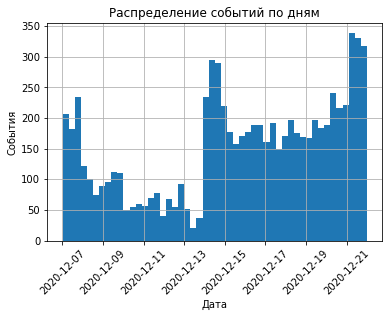

In [78]:
ax = df['event_dt'].hist(bins=50)
plt.title('Распределение событий по дням')
plt.ylabel("События")
plt.xlabel("Дата")
plt.xticks(rotation=45)
plt.show()

После 14 декабря начинается резкий рост количества событий

Посмотрим на распределение событий в каждой группе

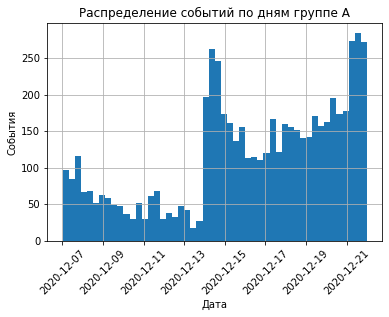

In [79]:
ax = df[df['group']== 'A']['event_dt'].hist(bins=50)
plt.title('Распределение событий по дням группе А')
plt.ylabel("События")
plt.xlabel("Дата")
plt.xticks(rotation=45)
plt.show()

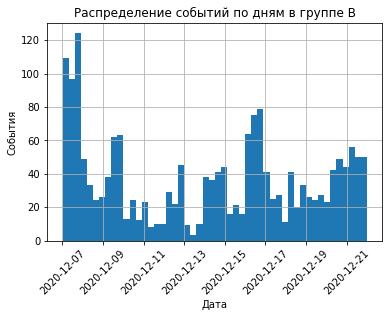

In [80]:
ax = df[df['group']== 'B']['event_dt'].hist(bins=50)
plt.title('Распределение событий по дням в группе В')
plt.ylabel("События")
plt.xlabel("Дата")
plt.xticks(rotation=45)
plt.show()

В группах события распределены не равномерно. Как уже отмечалось ранее, в группе В количество событий меньше чем в А в 3,4 раза.

При этом в группе А основная масса событий приходиться на период после 14 декабря, а группе В события после всплеска в первых числах, затем резко падают и дальше распределяютс равномерно на этом уровне с периодическими спадами.

Можно говорить, что есть какие-то дополнительные факторы, которые влияют на распределения событий в группах.

Отфильтруем только уникальные пары пользователь - событие

In [81]:
df = df.drop_duplicates(['user_id', 'event_name'])

In [82]:
sales_funnel = df['event_name'].value_counts().reset_index()
sales_funnel = sales_funnel.reindex([0,1,3,2]).reset_index(drop=True)

sales_funnel

,index,event_name
0,login,3480
1,product_page,2178
2,product_cart,1026
3,purchase,1082


In [ ]:
fig = go.Figure(
    go.Funnel(
        y = sales_funnel['index'], 
        x = sales_funnel['event_name'], 
        textinfo = "value+percent initial+percent previous")
)

fig.update_layout(
    title_text='Воронка пользователей последовательно прошедших через все этапы',
    title_font_size=25,
    yaxis_title='Этапы',
)
fig.show();

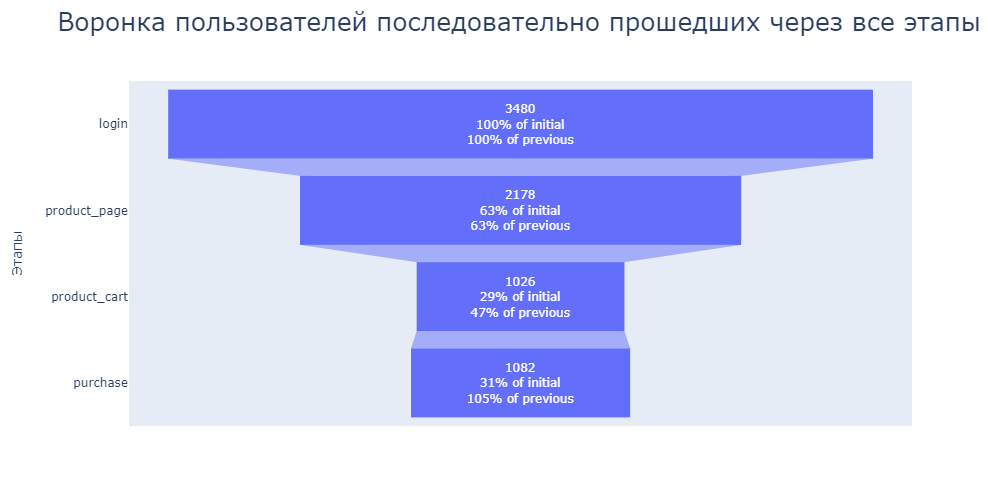

Можем сделать следующие выводы:

    Больше всего пользователей теряется после регистрации, до страницы продукта доходит лишь 63%
    Количество пользователей посетивших карту продукта меньше, чем количество пользователей купивших продукт. Такая ситуация могла произойти по нескольким причинам:
        на более ранних этапах появилась кнопка "быстрой покупки" и пользователи не заходят на карточку товара
        данные не корректно отражают реальную картину. Либо названия этапов перепутаны, либо на этапе сбора данных произошел какой-то сбой.
        
Все это, так же указывает на то, что подготовка к тесту и сбор данных были проведены не качественно.

In [84]:
df_a = df[df['group']=='A'][['user_id', 'first_date', 'event_dt', 'event_name', 'details', 'device']]
df_b = df[df['group']=='B'][['user_id', 'first_date', 'event_dt', 'event_name', 'details', 'device']]

Посмотрим на воронки продах в обеих группах

In [85]:
sales_funnel_a = df_a['event_name'].value_counts().reset_index()
sales_funnel_a = sales_funnel_a.reindex([0,1,3,2]).reset_index(drop=True)
sales_funnel_a

,index,event_name
0,login,2604
1,product_page,1685
2,product_cart,782
3,purchase,833


In [ ]:
fig = go.Figure(
    go.Funnel(
        y = sales_funnel_a['index'], 
        x = sales_funnel_a['event_name'], 
        textinfo = "value+percent initial+percent previous")
)

fig.update_layout(
    title_text='Воронка продаж пользователей группы А',
    title_font_size=25,
    yaxis_title='Этапы',
)
fig.show();

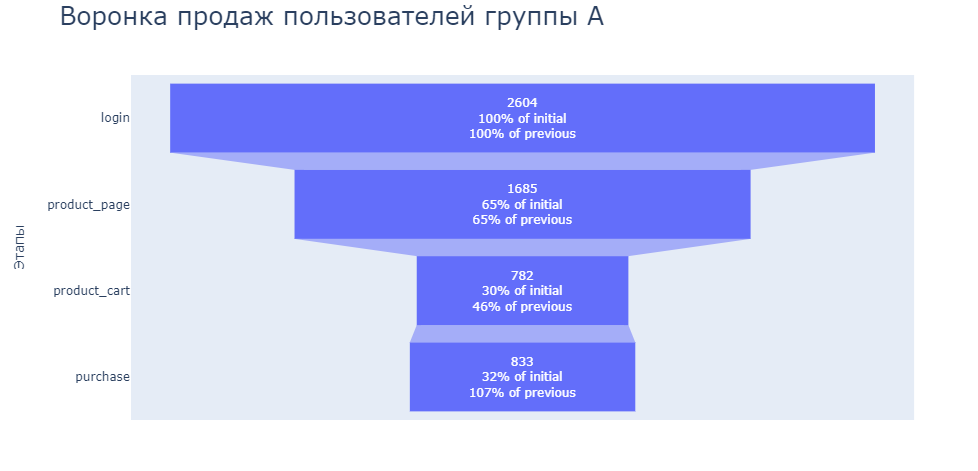

In [87]:
sales_funnel_b = df_b['event_name'].value_counts().reset_index()
sales_funnel_b = sales_funnel_b.reindex([0,1,3,2]).reset_index(drop=True)
sales_funnel_b

,index,event_name
0,login,876
1,product_page,493
2,product_cart,244
3,purchase,249


In [ ]:
fig = go.Figure(
    go.Funnel(
        y = sales_funnel_b['index'], 
        x = sales_funnel_b['event_name'], 
        textinfo = "value+percent initial+percent previous")
)

fig.update_layout(
    title_text='Воронка продаж пользователей группы B',
    title_font_size=25,
    yaxis_title='Этапы',
)
fig.show();

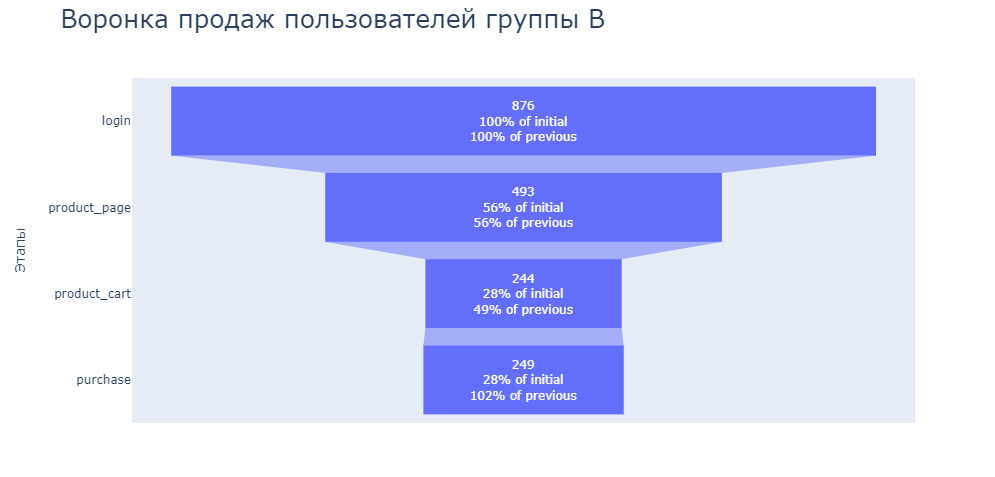

***Вывод***
В целом результаты теста показали, что новая платежная воронка ни на одном из этапов не дала ожидаемого результата:
    на переходе на страницу продукта конверсия уменьшилась на 9%
    на переходе на страницу продукта уменьшилась на 2%, 
    при перходе к продаже конверсия упала на 4%
    этап просмотра корзины так и остался последним после покупки.
    
В целом, можно говорить, что тест проведен не корректно. 

Собранные данные не соответствуют техническому заданию:
    
    С 25 декабря 2020 года по 03 января 2021 года прооходила Christmas&New Year Promo. По датам это совпало с проведением теста. Нам пришлось удалить данные, которые попали на этот период.
    Регистрация пользователей проводилась за рамками периода, который был озвучен в техническом задании. Эти данные тоже пришлось удалить.
    Были выявлены 1602 пользователя, которые одновременно участвовали в двух разных тестах. Было принято решение не удалять эти данные, чтобы столь значительное уменьшение количества пользователей не оказало еще более негативное влияние на результаты теста.
    В группе А пользователей оказалось больше почти в 3 раза. 
    Количество событий в группе А больше в 3,4 раза, чем в группе В.
    В группах события распределены не равномерно. При этом в группе А основная масса событий приходиться на период после 14 декабря, а группе В события после всплеска в первых числах, затем резко падают и дальше распределяютс равномерно на этом уровне с периодическими спадами.

Можно говорить, что есть какие-то дополнительные факторы, которые влияют на распределения событий в группах.
    
На стадии изучения первично воронки продаж были выявлены следующие факты:

    Больше всего пользователей теряется на после регистрации, до страницы продукта доходит лишь 63%
    Количество пользователей посетивших карту продукта меньше, чем количество пользователей купивших продукт. Такая ситуация могла произойти по нескольким причинам:
        на более ранних этапах появилась кнопка "быстрой покупки" и пользователи не заходят на карточку товара
        данные не корректно отражают реальную картину. 
        Либо названия этапов перепутаны, 
        либо на этапе сбора данных произошел какой-то сбой.
        Так же возможен вариант, что на воронку повлиял конкурирующий тест, причем, в меньшей степени это отразилось на тестовой группе.
        
Все это, так же указывает на то, что подготовка к тесту и сбор данных были проведены не качественно.


# Проверка статестической разницы долей z - критерием

Создадим сводную таблицу

In [89]:
user_id_count = df.groupby('group')['user_id'].nunique()
#user_id_count['A_B'] = user_id_count.A + user_id_count.B
user_id_count

group
A    2604
B     877
Name: user_id, dtype: int64

In [90]:
event_group = df.pivot_table(
    index='event_name', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').sort_values(by='A', ascending=False)
event_group.reset_index()
event_group['A_B'] = event_group.A + event_group.B
event_group['perc_a'] = (event_group.A / user_id_count.A * 100).round(2)
event_group['perc_b'] = (event_group.B / user_id_count.B * 100).round(2)
event_group

group,A,B,A_B,perc_a,perc_b
event_name,,,,,
login,2604,876,3480,100.00,99.89
product_page,1685,493,2178,64.71,56.21
purchase,833,249,1082,31.99,28.39
product_cart,782,244,1026,30.03,27.82


In [91]:
users = df.groupby('group')['user_id'].nunique().reset_index()
users = users.set_index(users.columns[0])
users

,user_id
group,
A,2604
B,877


Напишем функцию

In [92]:
def z_test(group1, group2, event, alpha): 
    p1_event = event_group.loc[event, group1]
    p2_event = event_group.loc[event, group2] 
    p1_users = users.loc[group1, 'user_id'] 
    p2_users = users.loc[group2, 'user_id'] 
    p1 = p1_event / p1_users 
    p2 = p2_event / p2_users 
    difference = p1 - p2
    p_combined = (p1_event + p2_event) / (p1_users + p2_users) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    bonferroni_alpha = alpha / 4
    
    print('Проверка для групп {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(group1, group2, event, p_value=p_value))
    if (p_value < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу о равенстве конверсии в группах")
    else:
        print("Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах")

***Сформулируем гипотезы***

    H0: Конверсия в группе A равна конверсии в группе B
    H1: Конверсия в группе A не равна конверсии в группе B

In [93]:
for event_name in event_group.index:
    z_test('A', 'B', event_name, 0.05)
    print()

Проверка для групп A и B, событие: login, p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для групп A и B, событие: product_page, p-значение: 0.00
Отвергаем нулевую гипотезу о равенстве конверсии в группах

Проверка для групп A и B, событие: purchase, p-значение: 0.05
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах

Проверка для групп A и B, событие: product_cart, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу о равенстве конверсии в группах



***Вывод***

В группах А и В 

    - в событии login конверсии равны
    - в событии product_page конверсии не равны
    - в событии purchase конверсии равны
    - в событии product_cart конверсии равны

# Вывод

Мы изучили полученные данные.

final_ab_events:

    Обнаружены пропуски в деталях событий. Принято решение заменить пропуски на 0
    Конечные выводы делать рано, но, на первый взгляд, воронка выглядит так:

    1. login           189552
    2. product_page    125563
    3. purchase         62740
    4. product_cart     62462
    Было бы логичным, если бы последним этапом была покупка.
    
ab_project_marketing_events:

    С 25 декабря 2020 года по 03 января 2021 года прооходила Christmas&New Year Promo. Она полностью попадает на время нашего эксперемента и проходила в Европе (EU). Это событие может сильно повлиять на результат нашего тестирования. Принято решение удалить из теста события, которые будут пересекаться с этой акцией.
    
final_ab_new_users:
    
    Поменяли  тип данных в столбце с датами 
    Было выявлено не соответствие данных с техническим заданием. Регистрация пользователей продолжалась после 21 декабря. Эти пользователи были удалени из данных.
    
    
final_ab_participants:
    
    Были выявлены пользоваталеи, которые одновременной участвовали во втором тесте
    Количество пользователей, которые попали в оба теста:  1602. Не стали их удалять, так как это могло значительно повлиять на результаты нашего анализа.
    
Изучив результаты тестов сделаны следующие выводы:

В целом результаты теста показали, что новая платежная воронка ни на одном из этапов не дала ожидаемого результата:
    на переходе на страницу продукта конверсия уменьшилась на 9%
    на переходе на страницу продукта уменьшилась на 2%, 
    при перходе к продаже конверсия упала на 4%
    этап просмотра корзины так и остался последним после покупки.
    
Можно однозначно сказать, что тест проведен не корректно. 

Собранные данные не соответствуют техническому заданию:
    
    С 25 декабря 2020 года по 03 января 2021 года прооходила Christmas&New Year Promo. По датам это совпало с проведением теста. Нам пришлось удалить данные, которые попали на этот период.
    Регистрация пользователей проводилась за рамками периода, который был озвучен в техническом задании. Эти данные тоже пришлось удалить.
    Были выявлены 1602 пользователя, которые одновременно участвовали в двух разных тестах. Было принято решение не удалять эти данные, чтобы столь значительное уменьшение количества пользователей не оказало еще более негативное влияние на результаты теста.
    В группе А пользователей оказалось больше почти в 3 раза. 
    Количество событий в группе А больше в 3,4 раза, чем в группе В.
    
На стадии изучения первичной воронки продаж были выявлены следующие факты:

    Больше всего пользователей теряется на после регистрации, до страницы продукта доходит лишь 63%
    Количество пользователей посетивших карту продукта меньше, чем количество пользователей купивших продукт. Такая ситуация могла произойти по нескольким причинам:
        на более ранних этапах появилась кнопка "быстрой покупки" и пользователи не заходят на карточку товара
        данные не корректно отражают реальную картину. 
        Либо названия этапов перепутаны, 
        либо на этапе сбора данных произошел какой-то сбой.
        Так же возможен вариант, что на воронку повлиял конкурирующий тест, причем, в меньшей степени это отразилось на тестовой группе.
        
Все это, так же указывает на то, что подготовка к тесту и сбор данных были проведены не качественно.

Результат проверки статистической разницы долей z- критерием подтверждают наши выводы результах теста.

В трех из четырех случаев нам не удалось отвергнуть нулевую гипотезе о равенстве конверсии.

Необходимо проверить все условия, при которых проводился этот тест. Есть вопросы по очередности  этапов в воронке продаж. 
Найти причины не корректно собранных данных. Это можеть быть чья-то халатность. а может какой-то технической сбой. который необходимо устарнить. 

Желательно избегать параллельного проведения конкурирующих двух и более тестов, особенно если нет возможности сформировать достоточные выборки, чтобы они не пересекались. 

Избегать проведения тестов по времени совпадающих с большими маркетинговыми мероприятиями.